# Tarea 1, Ejercicio 9

Una estación de servicio maneja cuatro bombas de gasolina. El tiempo de servicio a un cliente tiene una distribución exponencial con una media de cinco minutos. Los automóviles llegan a la gasolinera con una distribución de Poisson con una tasa de 30 por hora. Si llega un automóvil y no hay bombas disponibles, la venta se pierde. Si la venta promedio de gasolina es de $ 40 por automóvil.

**a)**	¿Cuánto podría esperar perder diariamente el dueño de la estación, debido a la impaciencia de los automovilistas?

**b)**	Si la probabilidad de que un automovilista se niegue a esperar a que se desocupe una bomba es de 0.5. ¿Cuánto podría esperar perder diariamente el dueño de la estación, debido a la impaciencia de los automovilistas?

## Especificaciones de la simulación parte A
En este caso la simulación no tiene cola pero maneja 4 servidores que corresponden a las cuatro bombas de la estación, inicia con todas las bombas disponibles (0 es disponible y 1 es ocupado) y con el reloj de la simulación en 0.0 minutos

# Resultados
Se procesó el día que duró la simulación y todos los eventos en minutos y luego en el reporte se promedió con respecto al número de días que se corrió la simulación (1000 veces), además de otras estadísticas que ayudan a un análisis más profundo de la situación cómo el promedio de uso díario de cada bomba, el promedio de los clientes atendidos y el promedio de lo que se ganó o dejó de ganar diariamente. Con esto se sacó un intervalo de 95% de confianza.

----------------------------------------
Queueing System: Daily Losses in a Four-Pump Gas Station
----------------------------------------
Mean Daily Loss: $4280.11
95% Confidence Interval for Daily Loss: $4240.82 to $4319.40
Average daily customers: 719.82
Average daily customers served: 612.82
Mean percentage of customers leaving unattended daily: 14.83%
Mean Daily usage of pump 1: 1029.615 minutes, pump 2: 871.084 minutes, pump 3: 680.300 minutes, and pump 4: 474.160 minutes
----------------------------------------


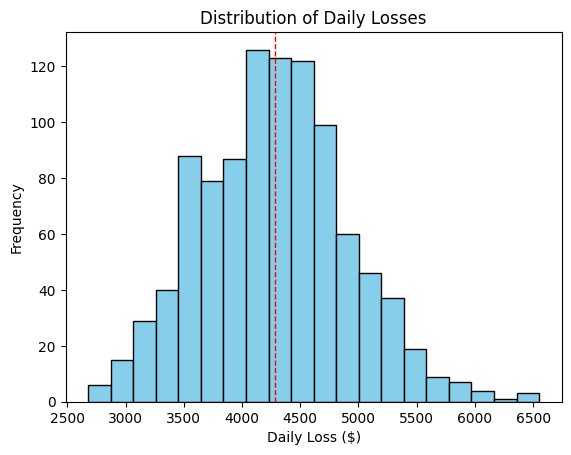

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(1)

class MM1_Queue:

    def __init__(self, num_days_required):

        # Parámetros de entrada
        self.mean_interarrival = 2.0 # Tiempo medio entre un auto y otro en minutos (30 autos por hora)
        self.mean_service = 5.0 # Tiempo medio de servicio (5 minutos)
        self.num_days_required = num_days_required # Días de funcionamiento de la estación de servicio
        self.num_min_required = self.num_days_required * 1440 # minutos de funcionamiento de la estación de servicio

        # Variables de estado
        self.server_status = [0, 0, 0, 0] # 0 en idle y 1 en busy
        self.time_last_event = 0.0

        # Contadores estadísticos
        self.num_cust_left = 0 # Numero de compradores que se van sin ser atendidos
        self.num_cust_served = 0 # Numero de compradores que son atendidos
        self.area_server_status = [0.0, 0.0, 0.0, 0.0] # Área bajo la curva de estado del servidor para cada bomba

        # Reloj de simulación
        self.sim_time = 0.0

        # Lista de eventos
        self.time_next_event = [0, float('inf'), float('inf'), float('inf'), float('inf')]
        self.time_next_event[0] = self.sim_time + self.expon(self.mean_interarrival)
        self.pump_event = [None, None, None, None] # No se toma en cuenta el índice 0 y los otros elementos reflejan las 4 bombas

        # Otras variables
        self.num_pumps = 4

    def main(self):

        # Corre la simulación mientras se necesiten más minutos
        while (self.sim_time < self.num_min_required):

            # Determina cuál es el próximo evento
            self.timing()
            # Actualiza las estadísticas
            self.update_time_avg_stats()
            # Llama la función que le corresponde al evento ( tipo 1 es llegada y tipo 2 partida)
            if (self.next_event_type == 1):
                self.arrive()
            elif (self.next_event_type == 2):
                self.depart()
            else:
                break


    def timing(self):

        # Variables necesarias para buscar en la lista de eventos el tiempo mínimo
        self.min_time_next_event = float('inf')
        self.next_event_type = 0

        # Determina el tipo de evento que ocurrirá en cada sistema
        for i in range(0, self.num_pumps + 1):

            if(self.time_next_event[i] < self.min_time_next_event):
                self.min_time_next_event = self.time_next_event[i]
                if (i > 0):
                    self.next_event_type = 2
                else:
                    self.next_event_type = 1

        # Verificar si todos los eventos de la lista tienen valor infinito para detener la simulación
        if (self.next_event_type == 0) :
            raise Exception ("All entries in the event list have infinite values, so stop the simulation")

        # Si algun valor en la lista es finito, avanza el reloj de simulación
        self.sim_time = self.min_time_next_event

    def arrive(self):

        # Programar la próxima llegada
        self.time_next_event[0] = self.sim_time + self.expon(self.mean_interarrival)

        # Verificar disponibilidad de las bombas
        self.available_pump = None
        for i, status in enumerate(self.server_status):
            if status == 0:  # Bomba disponible
                self.available_pump = i
                break

        if self.available_pump is not None:

            # Asignar cliente a la bomba disponible y marcarla como ocupada
            self.server_status[self.available_pump] = 1
            self.num_cust_served += 1

            # Programar evento de partida para esta bomba
            self.time_next_event[self.available_pump + 1] = self.sim_time + self.expon(self.mean_service)

            # Actualiza para reflejar esta nueva asignación
            self.pump_event[self.available_pump] = 1

        else:
            # Todas las bombas están ocupadas, el cliente se va
            self.num_cust_left += 1


    def depart(self):

        for i, pump in enumerate(self.pump_event):

            if pump is not None and self.time_next_event[i + 1] == self.sim_time :
                # Marcar la bomba como libre
                self.server_status[i] = 0

                # Asegurar que no hay más eventos de partida programados para esta bomba
                self.time_next_event[i + 1] = float('inf')

                # Eliminar el mapeo del evento de partida, ya que ha sido procesado
                self.pump_event[i] = None

                break

    def update_time_avg_stats(self):

        #Calcula el tiempo desde el último evento
        self.time_since_last_event = self.sim_time - self.time_last_event
        self.time_last_event = self.sim_time

        for i in range(self.num_pumps):
            self.area_server_status[i] += self.server_status[i] * self.time_since_last_event

    def expon(self, mean):

        return (-mean * np.log(np.random.uniform(0,1)))





def perform_simulation(num_days_required, num_simulations):
    losses = []
    daily_customers = []
    daily_customers_served = []
    percentage_customers_leaving = []
    usage_pump1 = []
    usage_pump2 = []
    usage_pump3 = []
    usage_pump4 = []

    for _ in range(num_simulations):
        model = MM1_Queue(num_days_required)
        model.main()
        losses.append((model.num_cust_left/(model.sim_time/1440)) * 40)  # $40 por cliente no atendido
        daily_customers.append((model.num_cust_left + model.num_cust_served)/(model.sim_time/1440))
        daily_customers_served.append(model.num_cust_served/(model.sim_time/1440))
        percentage_customers_leaving.append((model.num_cust_left/(model.num_cust_served + model.num_cust_left)) * 100)
        usage_pump1.append(model.area_server_status[0]/(model.sim_time/1440))
        usage_pump2.append(model.area_server_status[1]/(model.sim_time/1440))
        usage_pump3.append(model.area_server_status[2]/(model.sim_time/1440))
        usage_pump4.append(model.area_server_status[3]/(model.sim_time/1440))

    return losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4

def analyze_results(losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4):
    mean_loss = np.mean(losses)
    mean_daily_customers = np.mean(daily_customers)
    mean_daily_customers_served = np.mean(daily_customers_served)
    mean_percentage = np.mean(percentage_customers_leaving)
    mean_pump1 = np.mean(usage_pump1)
    mean_pump2 = np.mean(usage_pump2)
    mean_pump3 = np.mean(usage_pump3)
    mean_pump4 = np.mean(usage_pump4)
    conf_interval = stats.t.interval(0.95, len(losses)-1, loc=mean_loss, scale=stats.sem(losses))
    return mean_loss, conf_interval, mean_daily_customers, mean_daily_customers_served, mean_percentage, mean_pump1, mean_pump2, mean_pump3, mean_pump4

# Realizar la simulación
num_days_required = 1
num_simulations = 1000
losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4 = perform_simulation(num_days_required, num_simulations)

# Analizar los resultados
mean_loss, conf_interval, mean_daily_customers, mean_daily_customers_served, mean_percentage, mean_pump1, mean_pump2, mean_pump3, mean_pump4 = analyze_results(losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4)

print("-"*40)
print("Queueing System: Daily Losses in a Four-Pump Gas Station")
print("-"*40)
print(f"Mean Daily Loss: ${mean_loss:.2f}")
print(f"95% Confidence Interval for Daily Loss: ${conf_interval[0]:.2f} to ${conf_interval[1]:.2f}")
print("Average daily customers: {:.2f}".format(mean_daily_customers))
print("Average daily customers served: {:.2f}".format(mean_daily_customers_served))
print("Mean percentage of customers leaving unattended daily: {:.2f}%".format(mean_percentage))
print("Mean Daily usage of pump 1: {:.3f} minutes, pump 2: {:.3f} minutes, pump 3: {:.3f} minutes, and pump 4: {:.3f} minutes".format(mean_pump1, mean_pump2, mean_pump3, mean_pump4))
print("-"*40)

# Visualización
plt.hist(losses, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Losses')
plt.xlabel('Daily Loss ($)')
plt.ylabel('Frequency')
plt.axvline(mean_loss, color='r', linestyle='dashed', linewidth=1)
plt.show()




## Especificaciones de la simulación parte B
En este caso la simulación si tiene cola y la probabilidad de que un cliente decida esperar es del 50%, maneja todo similar al punto anterior pero aquí se modifica la función de partida para procesar la cola, también se realizó la simulación 1000 veces.

# Resultados
El reporte es el mismo que en el punto anterior pero se agregó uno más, el promedio de espera de un cliente en la cola.
Se obtuvo un intervalo de confianza del 95% y se evidencia uuna reducción en las pérdidas de alrededor del 32%.


----------------------------------------
Queueing System: Daily Losses in a Four-Pump Gas Station
----------------------------------------
Mean Daily Loss: $2892.48
95% Confidence Interval for Daily Loss: $2862.66 to $2922.31
Average daily customers: 718.76
Average daily customers served: 646.44
Mean percentage of customers leaving unattended daily: 10.03%
Average delay in queue: 1.778 minutes
Mean Daily usage of pump 1: 1052.451 minutes, pump 2: 906.376 minutes, pump 3: 727.154 minutes, and pump 4: 533.801 minutes
----------------------------------------


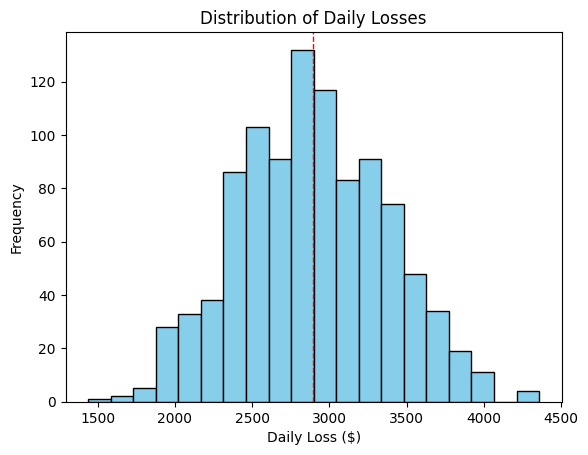

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(1)

class MM1_Queue:

    def __init__(self, num_days_required):

        # Parámetros de entrada
        self.mean_interarrival = 2.0 # Tiempo medio entre un auto y otro en minutos (30 autos por hora)
        self.mean_service = 5.0 # Tiempo medio de servicio (5 minutos)
        self.num_days_required = num_days_required # Días de funcionamiento de la estación de servicio
        self.num_min_required = self.num_days_required * 1440 # minutos de funcionamiento de la estación de servicio

        # Variables de estado
        self.server_status = [0, 0, 0, 0] # 0 en idle y 1 en busy
        self.time_last_event = 0.0
        self.num_in_q = 0
        self.time_arrival = [] # Lista para el tiempo de llegada de los compradores

        # Contadores estadísticos
        self.num_cust_left = 0 # Numero de compradores que se van sin ser atendidos
        self.num_cust_served = 0 # Numero de compradores que son atendidos
        self.area_server_status = [0.0, 0.0, 0.0, 0.0] # Área bajo la curva de estado del servidor para cada bomba
        self.area_num_in_q = 0.0
        self.total_of_delays = 0.0
        self.num_cust_delayed = 0

        # Reloj de simulación
        self.sim_time = 0.0

        # Lista de eventos
        self.time_next_event = [0, float('inf'), float('inf'), float('inf'), float('inf')]
        self.time_next_event[0] = self.sim_time + self.expon(self.mean_interarrival)
        self.pump_event = [None, None, None, None] # No se toma en cuenta el índice 0 y los otros elementos reflejan las 4 bombas

        # Otras variables
        self.num_pumps = 4

    def main(self):

        # Corre la simulación mientras se necesiten más minutos
        while (self.sim_time < self.num_min_required):

            # Determina cuál es el próximo evento
            self.timing()
            # Actualiza las estadísticas
            self.update_time_avg_stats()
            # Llama la función que le corresponde al evento (tipo 1 es llegada y tipo 2 partida)
            if (self.next_event_type == 1):
                self.arrive()
            elif (self.next_event_type == 2):
                self.depart()
            else:
                break


    def timing(self):

        # Variables necesarias para buscar en la lista de eventos el tiempo mínimo
        self.min_time_next_event = float('inf')
        self.next_event_type = 0

        # Determina el tipo de evento que ocurrirá en cada sistema
        for i in range(0, self.num_pumps + 1):

            if(self.time_next_event[i] < self.min_time_next_event):
                self.min_time_next_event = self.time_next_event[i]
                if (i > 0):
                    self.next_event_type = 2
                else:
                    self.next_event_type = 1

        # Verificar si todos los eventos de la lista tienen valor infinito para detener la simulación
        if (self.next_event_type == 0) :
            raise Exception ("All entries in the event list have infinite values, so stop the simulation")

        # Si algun valor en la lista es finito, avanza el reloj de simulación
        self.sim_time = self.min_time_next_event

    def arrive(self):

        # Programar la próxima llegada
        self.time_next_event[0] = self.sim_time + self.expon(self.mean_interarrival)

        # Verificar disponibilidad de las bombas
        self.available_pump = None
        for i, status in enumerate(self.server_status):
            if status == 0:  # Bomba disponible
                self.available_pump = i
                break

        if self.available_pump is not None:

            # Asignar cliente a la bomba disponible y marcarla como ocupada
            self.server_status[self.available_pump] = 1
            self.num_cust_served += 1

            # Programar evento de partida para esta bomba
            self.time_next_event[self.available_pump + 1] = self.sim_time + self.expon(self.mean_service)

            # Actualizar para reflejar esta nueva asignación
            self.pump_event[self.available_pump] = 1

        else:
            # Todas las bombas están ocupadas, decide basado en la probabilidad si el cliente se va
            if np.random.rand() < 0.5:
                # El cliente decide no esperar y se va
                self.num_cust_left += 1
            else:
                # Se forma una cola
                self.num_in_q += 1
                self.num_cust_served += 1
                self.time_arrival.append(self.sim_time)



    def depart(self):

        for i, pump in enumerate(self.pump_event):

            if pump is not None and self.time_next_event[i + 1] == self.sim_time:
                # Marcar la bomba como libre
                self.server_status[i] = 0

                # Asegurar que no hay más eventos de partida programados para esta bomba
                self.time_next_event[i + 1] = float('inf')
                self.pump_event[i] = None

                if self.num_in_q > 0:

                    # Hay clientes en espera, asigna el siguiente en la cola a esta bomba
                    self.num_in_q -= 1
                    self.server_status[i] = 1

                    self.delay = self.sim_time - self.time_arrival[0]
                    self.total_of_delays += self.delay

                    # Incrementa el número de clientes retrasados y agenda una partida
                    self.num_cust_delayed += 1
                    self.time_next_event[i + 1] = self.sim_time + self.expon(self.mean_service)
                    self.pump_event[i] = 1  # Indicar que esta bomba ahora está ocupada con un nuevo cliente

                    # Elimina el cliente que está de primeras en la fila
                    del self.time_arrival [0]

                # Si no hay clientes en espera, simplemente se libera la bomba y se espera el próximo evento
                break


    def update_time_avg_stats(self):

        #Calcula el tiempo desde el último evento
        self.time_since_last_event = self.sim_time - self.time_last_event
        self.time_last_event = self.sim_time

        for i in range(self.num_pumps):
            self.area_server_status[i] += self.server_status[i] * self.time_since_last_event

    def expon(self, mean):

        return (-mean * np.log(np.random.uniform(0,1)))


def perform_simulation(num_days_required, num_simulations):
    losses = []
    daily_customers = []
    daily_customers_served = []
    percentage_customers_leaving = []
    delay_queue = []
    usage_pump1 = []
    usage_pump2 = []
    usage_pump3 = []
    usage_pump4 = []

    for _ in range(num_simulations):
        model = MM1_Queue(num_days_required)
        model.main()
        losses.append((model.num_cust_left/(model.sim_time/1440)) * 40)  # $40 por cliente no atendido
        daily_customers.append((model.num_cust_left + model.num_cust_served)/(model.sim_time/1440))
        daily_customers_served.append(model.num_cust_served/(model.sim_time/1440))
        percentage_customers_leaving.append((model.num_cust_left/(model.num_cust_served + model.num_cust_left)) * 100)
        usage_pump1.append(model.area_server_status[0]/(model.sim_time/1440))
        usage_pump2.append(model.area_server_status[1]/(model.sim_time/1440))
        usage_pump3.append(model.area_server_status[2]/(model.sim_time/1440))
        usage_pump4.append(model.area_server_status[3]/(model.sim_time/1440))
        delay_queue.append(model.total_of_delays/model.num_cust_delayed)

    return losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4, delay_queue

def analyze_results(losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4, delay_queue):
    mean_loss = np.mean(losses)
    mean_daily_customers = np.mean(daily_customers)
    mean_daily_customers_served = np.mean(daily_customers_served)
    mean_percentage = np.mean(percentage_customers_leaving)
    mean_pump1 = np.mean(usage_pump1)
    mean_pump2 = np.mean(usage_pump2)
    mean_pump3 = np.mean(usage_pump3)
    mean_pump4 = np.mean(usage_pump4)
    mean_delay = np.mean(delay_queue)
    conf_interval = stats.t.interval(0.95, len(losses)-1, loc=mean_loss, scale=stats.sem(losses))
    return mean_loss, conf_interval, mean_daily_customers, mean_daily_customers_served, mean_percentage, mean_pump1, mean_pump2, mean_pump3, mean_pump4, mean_delay

# Realizar la simulación
num_days_required = 1
num_simulations = 1000
losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4, delay_queue = perform_simulation(num_days_required, num_simulations)

# Analizar los resultados
mean_loss, conf_interval, mean_daily_customers, mean_daily_customers_served, mean_percentage, mean_pump1, mean_pump2, mean_pump3, mean_pump4, mean_delay = analyze_results(losses, daily_customers, daily_customers_served, percentage_customers_leaving, usage_pump1, usage_pump2, usage_pump3, usage_pump4, delay_queue)

print("-"*40)
print("Queueing System: Daily Losses in a Four-Pump Gas Station")
print("-"*40)
print(f"Mean Daily Loss: ${mean_loss:.2f}")
print(f"95% Confidence Interval for Daily Loss: ${conf_interval[0]:.2f} to ${conf_interval[1]:.2f}")
print("Average daily customers: {:.2f}".format(mean_daily_customers))
print("Average daily customers served: {:.2f}".format(mean_daily_customers_served))
print("Mean percentage of customers leaving unattended daily: {:.2f}%".format(mean_percentage))
print("Average delay in queue: {:.3f} minutes".format(mean_delay))
print("Mean Daily usage of pump 1: {:.3f} minutes, pump 2: {:.3f} minutes, pump 3: {:.3f} minutes, and pump 4: {:.3f} minutes".format(mean_pump1, mean_pump2, mean_pump3, mean_pump4))
print("-"*40)

# Visualización
plt.hist(losses, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Losses')
plt.xlabel('Daily Loss ($)')
plt.ylabel('Frequency')
plt.axvline(mean_loss, color='r', linestyle='dashed', linewidth=1)
plt.show()